### this notebook compares my results to the outputs of the new repo that Chirag created

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
sys.path.append("../scripts/") 
from lab import *
import os

In [71]:
##general settings
LSST      = True
#if not LSST redhsift kernel
z0        = 1.
sigma_z   = 0.1
bin_num   = 'all'
bias      = 'simple'
z_source  = z_cmb
zmax      = z_source
chimax    = chi_z(zmax)

stylelabel= 'seaborn-colorblind'

In [72]:
#check if parameters correspond to saved ones

if z_source==z_cmb:
    chi_source = chi_cmb
else:
    chi_source = chi_z(z_source)

if LSST:
    if chi_source==chi_cmb:
        file_ext = 'lsst%s_cmblens_'%str(bin_num)
    else:
        file_ext = 'lsst%s_deltalens_z%d_'%(str(bin_num),z_source*10)
else:
    if chi_source==chi_cmb:
        file_ext = 'gaussgal_z%d_sigma%d_cmblens_'%(z0*10,sigma_z*10)
    else:
        file_ext = 'gaussgal_z%d_sigma%d_deltalens_z%d_'%(z0*10,sigma_z*10,z_source*10) 
    
file_ext+=bias+'_bias'

file_ext+=  '_zmax%d'%(zmax*10)
file_ext2 = 'zmax%d'%(zmax*10)
    
print('file extensions for this run:', file_ext,',', file_ext2)


if bias == 'simple':
    bias_func = simple_bias
elif bias =='constant':
    bias_func = constant_bias
else:
    print('no valid bias function selected')



params = {}
params['LSST'] = LSST
params['z0'] = z0
params['sigma_z'] = sigma_z
params['bin_num'] = bin_num
params['chimax'] = chimax
params['chisource'] = chi_source
params['zsource'] = z_source
params['ext'] = file_ext
params['ext2']= file_ext2
params['bias']=bias

params_ = pickle.load(open('../settings/params_%s.pkl'%file_ext,'rb'))

for key in params.keys():
    assert(params[key]==params_[key])


file extensions for this run: lsstall_cmblens_simple_bias_zmax10886 , zmax10886


In [73]:
plotpath = '../plots/%s/'%file_ext
if os.path.isdir(plotpath):
    print('plot path exists')
else:
    os.mkdir(plotpath)

plot path exists


In [74]:
print('delta lensing with chimax %d'%chimax)
def lensing_kernel(xi):
    xmax = chi_source
    return (xmax - xi)/(xmax*xi) * (xmax > xi)
    
if LSST:
    if bin_num == 'all':
        def galax_kernel(x):
            return lsst_kernel_cb(x)*simple_bias(x)
    else:
        def galax_kernel(x):
            return lsst_kernel_cbn[bin_num](x)*simple_bias(x)
else:
    kernel = gal_clus(Gauss_redshift(sigma_z=sigma_z,z0=z0), bias_func)
    def galax_kernel(x):
        return kernel(x)
    
print(galax_kernel(chimax))

delta lensing with chimax 9414
0.0


### plot redhift kernels

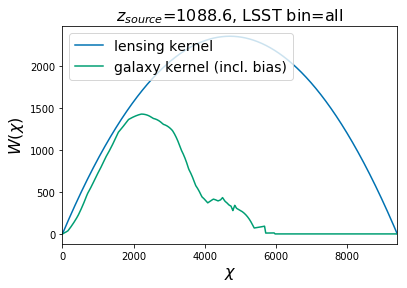

In [75]:
with plt.style.context(stylelabel):
    fig, ax1 = plt.subplots()
    if LSST:
        ax1.set_title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=16)
    else:
        ax1_title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=16)   
    chis = np.linspace(1,chimax,20000)
    ax1.plot(chis, lensing_kernel(chis)*chis**2,label='lensing kernel')
    ax1.plot(chis, galax_kernel(chis)*2e6, label='galaxy kernel (incl. bias)')
    ax1.set_xlabel('$\chi$',fontsize=16)
    ax1.set_ylabel('$W(\chi)$',fontsize=16)
    ax1.legend(loc='upper left',fontsize=14)
    ax1.set_xlim(0,chimax)
    fig.savefig(plotpath+'redshiftkernels_%s.png'%file_ext, bbox_inches='tight',dpi=400)

In [76]:

L = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)/2.),100)


#### leading order cross correlation and magnification bias

In [77]:
ell_,Cl_kg   = np.load('../output/cls/Clkg_%s.npy'%(file_ext))
ell_,J11bare = np.load('../output/cls/ClkgJacobianbare_%s.npy'%(file_ext))

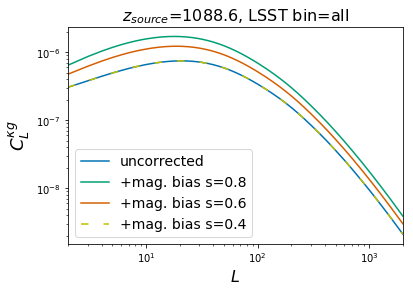

In [78]:
with plt.style.context(stylelabel):
    fig, ax1 = plt.subplots()
    if LSST:
        ax1.set_title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=16)
    else:
        ax1.set_title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=16)   
    ax1.loglog(ell_,Cl_kg,ls='-',label='uncorrected')
    for s in [0.8,0.6]:
        p=ax1.semilogx(ell_,J11bare*5.*(s-0.4)+Cl_kg,ls='-', label='+mag. bias s=%.1f'%s)
        ax1.semilogx(ell_,-(J11bare*5.*(s-0.4)+Cl_kg),ls='--', c=p[0].get_color())
    ax1.loglog(ell_,Cl_kg,ls=(0,(5,10)), color='y',label='+mag. bias s=%.1f'%0.4)
    ax1.set_xlabel('$L$',fontsize=16)
    ax1.set_ylabel(r'$C_L^{\kappa g}$', fontsize=18)
    ax1.legend(fontsize=14)
    ax1.set_xlim(min(ell_),max(ell_))
    fig.savefig(plotpath+'clkg_magbias_%s.png'%file_ext, bbox_inches='tight',dpi=400)


In [79]:
terms=[]
for ii in range(1,5):
    try:
        _, term= np.load('../output/results/term%d_%s.npy'%(ii,file_ext))
        terms+=[term]
    except:
        print('loading failed', ii)

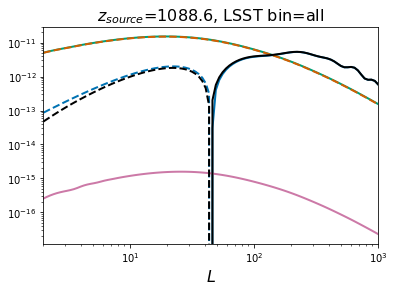

In [83]:
with plt.style.context(stylelabel):
    fig, ax1 = plt.subplots()
    if LSST:
        ax1.set_title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=16)
    else:
        ax1.set_title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=16)  
    #plt.title('Post Born terms (without Jacobian)',fontsize=14)
    p=ax1.loglog(L,terms[0],label='$\delta C_{L[22A]}+\delta C_{L[13a]}+\delta C_{L[31aA]}$',lw=2)
    ax1.loglog(L,-terms[0],ls='--',c=p[0].get_color(),lw=2)
    p=ax1.loglog(L,terms[1],label='$\delta C_{L[22B]}+\delta C_{L[31aB]}$',lw=2)
    ax1.loglog(L,-terms[1],ls='--',c=p[0].get_color(),lw=2)
    ax1.loglog(L,-terms[2],label='$-\delta C_{L[31b]}$',ls='--',lw=2)
    ax1.loglog(L,terms[3],label='$\delta C_{L[13b]}$',ls='-',lw=2)
    ax1.loglog(L,np.sum(terms, axis=0),ls='-',c='k',lw=2,label='sum')
    ax1.loglog(L,-(np.sum(terms,axis=0)),ls='--',c='k',lw=2)
    #add legend to the configuration where it fits best
    #ax1.legend(loc='best',fontsize=16, ncol=1)
    ax1.set_xlabel('$L$',fontsize=16)
    ax1.set_xlim(min(L),max(L))
    fig.savefig(plotpath+'postbornterms_%s.png'%file_ext, bbox_inches='tight',dpi=400)

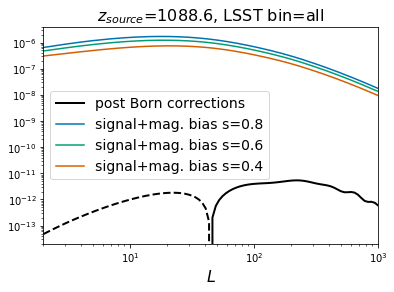

In [84]:
with plt.style.context(stylelabel):
    fig, ax1 = plt.subplots()
    if LSST:
        ax1.set_title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=16)
    else:
        ax1.set_title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=16)  
    #plt.title('Post Born terms (without Jacobian)',fontsize=14
    ax1.loglog(L,np.sum(terms, axis=0),ls='-',c='k',lw=2,label='post Born corrections')
    ax1.loglog(L,-(np.sum(terms,axis=0)),ls='--',c='k',lw=2)
    for s in [0.8,0.6,0.4]:
        p=ax1.semilogx(ell_,J11bare*5.*(s-0.4)+Cl_kg,ls='-', label='signal+mag. bias s=%.1f'%s)
        ax1.semilogx(ell_,-(J11bare*5.*(s-0.4)+Cl_kg),ls='--', c=p[0].get_color())
    #add legend to the configuration where it fits best
    ax1.legend(loc='best',fontsize=14, ncol=1)
    ax1.set_xlabel('$L$',fontsize=16)
    ax1.set_xlim(min(L),max(L))
    fig.savefig(plotpath+'postbornterms_vs_signal_%s.png'%file_ext, bbox_inches='tight',dpi=400)

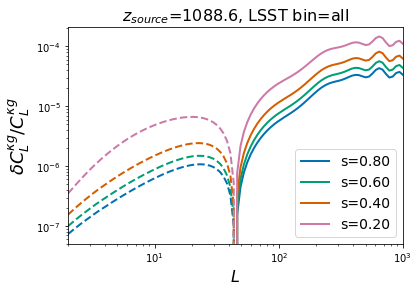

In [85]:
allterms = np.sum(terms, axis=0)
with plt.style.context(stylelabel):
    fig, ax1 = plt.subplots()
    if LSST:
        ax1.set_title('$z_{source}$=%.1f, LSST bin=%s'%(z_source, str(bin_num)),fontsize=16)
    else:
        ax1.set_title('$z_{source}$=%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z_source,z0, sigma_z),fontsize=16)  
    for s in [0.8,0.6,0.4,0.2]:
        corr_signal=(J11bare*5.*(s-0.4)+Cl_kg)
        p= ax1.loglog(L,allterms/np.interp(L,ell_,corr_signal),lw=2,label='s=%.2f'%s)
        ax1.loglog(L,-allterms/np.interp(L,ell_,corr_signal),lw=2,ls='--',color=p[0].get_color())



    ax1.legend(fontsize=14)
    ax1.set_xlim(min(L), max(L))
    ax1.set_xlabel('$L$',fontsize=16)
    ax1.set_ylabel('$\delta C_L^{\kappa g}/C_L^{\kappa g}$',fontsize=18)
    fig.savefig(plotpath+'signal_vs_corrections_%s_relative.png'%file_ext, bbox_inches='tight',dpi=400)